##  Reproducing Genetic Algorithm Generated CNC Cutting Parameters with a Neural Network

### Introduction

This notebook aims to reproduce the output data of *Multi-Objective Optimization of Turning Process during Machining of AlMg1SiCu (Aluminum) Using Non-Dominated Sorted Genetic Algorithm* by Rahul Dhabalea, VijayKumar S. Jattib, and T.P.Singhc. The study used a genetic algorithm (GA) to generate novel cutting parameters and predict material removal rate & surface roughness. The study can be found [here](https://www.sciencedirect.com/science/article/pii/S2211812814005318) for further reading but some explanation will follow, mainly concerning the differences between goals and the methodology used in creating the artificial neural network (ANN).

### Background

The GA used twenty-seven rows of input data that are a series of test cuts where a CNC machine tool was set to turn a constant diameter with a range of spindle speeds (rpm), feed rates (mm/rev), and depths of cut(mm). The results of each test cut take the form of a calculated material remove rate (mm$^3$/min) and surface roughness (μm) measurement. Their goal was to have the GA produce cutting conditions and results which maximized material removal rate and minimized surface roughness. These two outputs are conflicting in nature and so result in one ideal output for each scenario. In total the GA generated and ranked sixteen suggestions. Five of the sixteen results were chosen for validation of the GA results and tested on the CNC machine. The results had an average of less than five percent error from the forecast. 

### This Notebook

The major difference between the study and this notebook, besides the algorithm used, is in the prediction method. The ANN will be designed to accept a desired surface roughness as an input, and generate the spindle speed, feed rate, and depth of cut as outputs. The initial twenty-seven rows of cutting data will be used for training the neural network, while the five rows used for validation in the study will be split for the neural network into four rows of validation data and one row for testing the prediction of the final model. The four rows used for validation will be the real world cutting data from thte study, not the predicted values. The single row kept for testing the final model will have the lowest surface roughness value in the entire dataset. This makes for a more realistic test of the neaural network because an end user would likely be requesting CNC cutting parameters that result in better surface roughness meaurements than achieved when collecting the data. This input data will be outside anything the neaural network has been trained on which makes for a more difficult prediction. 

### Details

Usually a dataset's features very widely between magnitude, units, and range. For this reason, it's important to scale the data because most machine learning models recognize patterns using Euclidian distance between any two points. There are many ways to scale data but, in this notebook, the Standard method in the Scikit-Learn library will be applied. In the initial tests the MinMax scaler was also used, with both scaled data sets used with the Talos package to tune the hyperparameters of the neural network. The best results of each were applied to the Keras model for final results on the validation data. It was found for this problem the Standard scaler far surpassed the MinMax scaler, so it has been removed from the notebook. The material removal rate data, although having a higher linear correlation to the three outputs, was causing a worse model prediction when included and was dropped from the data before training. This is a simple calculated field from the three outputs so there is no need in "predicting" its value. 

### Conclusion

This notebook was made to show the feasibility in using a neural network, made with common open source tools, to facilitate process improvements in manufacturing by replicating the successful results of a GA and adjusting the input and output parameters to create a tool useful for the shop floor.

Test cuts of this nature will likely produce a very small amounts of data as seen in the study. Generally, in machine learning a much larger amount of data is required for a robust model to be created, that shortcoming can be seen here with the model's graphed validation accuracy and loss, but it appears an acceptable level of performance is achievable if enough domain knowledge around the data being collected can be applied and it's wrangled correctly. The predicted values show a much higher level of accuracy and consistency than the model's scoring during creation.

The final model is scores between 6 and 8 average percent error across the three predictions, with the RPM and feedrate consistently closer 5% and the depth of cut ranging between 10 to 15%. The fluctuation seen between model runs is caused by weights and bias in the ANN be itialized from zero at every start. The final predicted values and percent error can be seen below the graphs at the end of the notebook.

Other cutting or result data would likely need to be used to fit a real business model, for instance replacing material removal rate with some measure of process stability like tool life or "time since adjustment", but due to the proprietary nature of manufacturing the availably of real-world data is limited.

In [40]:
# # import dependencies
%matplotlib inline
import keras
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os
import time
from keras.models import Sequential
from keras.layers import Activation, Dense
# from keras.activations import *
# from keras.callbacks import *
# from keras.layers import *
# from keras.losses import *
# from keras.optimizers import *
# from keras.layers import advanced_activations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn
import seaborn as sns
import tensorflow as tf
# import sklearn
# from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# import talos as ta
# import warnings
# warnings.filterwarnings("ignore")

# # establish fixed seeding for reproducability
# seed_value= 0
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)
# import random
# random.seed(seed_value)
# import numpy as np
# np.random.seed(seed_value)
# import tensorflow as tf
# tf.set_random_seed(seed_value)
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

# # suppress NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

In [41]:
# import data
df = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
# look at the dataframe
df

,Sr._No.,Spindle_speed(rpm),Feed_rate(mm/rev),Depth_of_cut(mm),MRR(mm3/min),Ra(µm)
0,1,280,0.0508,0.40,306.67,0.36
1,2,280,0.0508,0.80,609.76,0.47
2,3,280,0.0508,1.20,909.28,0.52
3,4,280,0.1016,0.40,582.94,0.80
4,5,280,0.1016,0.80,1158.73,0.90
5,6,280,0.1016,1.20,1727.36,1.10
6,7,280,0.1524,0.40,943.34,1.63
7,8,280,0.1524,0.80,1875.96,1.76
8,9,280,0.1524,1.20,2797.84,2.17
9,10,710,0.0508,0.40,793.04,0.38


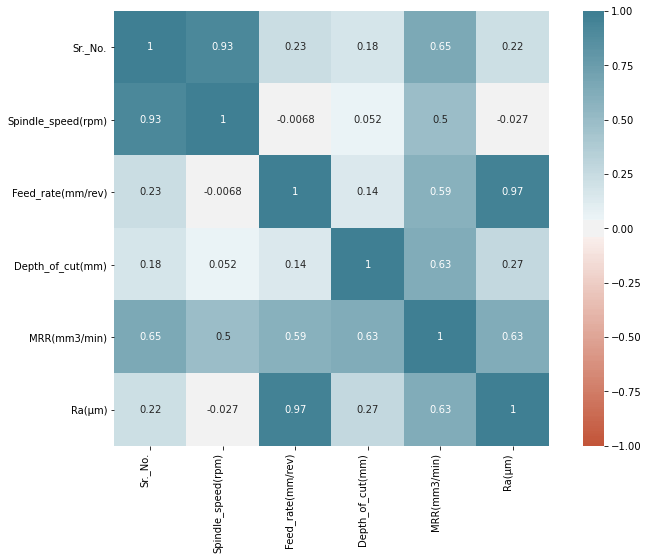

In [42]:
# visual correlation of raw data
heatMap = df
plt.figure(figsize=(12, 8))
corr = heatMap.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right')  # ;
plt.savefig('heat_map')

In [43]:
# drop the index number of the tests
df.drop(columns=['Sr._No.', 'MRR(mm3/min)'], inplace=True)

In [44]:
# load the data from the Pandas dataframe to a NumPy array.
# arrays are a simple data structure and are required for 
# scikit-learn algorithms to process data
np_data = df.values
np_data

array([[ 280.    ,    0.0508,    0.4   ,    0.36  ],
       [ 280.    ,    0.0508,    0.8   ,    0.47  ],
       [ 280.    ,    0.0508,    1.2   ,    0.52  ],
       [ 280.    ,    0.1016,    0.4   ,    0.8   ],
       [ 280.    ,    0.1016,    0.8   ,    0.9   ],
       [ 280.    ,    0.1016,    1.2   ,    1.1   ],
       [ 280.    ,    0.1524,    0.4   ,    1.63  ],
       [ 280.    ,    0.1524,    0.8   ,    1.76  ],
       [ 280.    ,    0.1524,    1.2   ,    2.17  ],
       [ 710.    ,    0.0508,    0.4   ,    0.38  ],
       [ 710.    ,    0.0508,    0.8   ,    0.48  ],
       [ 710.    ,    0.0508,    1.2   ,    0.54  ],
       [ 710.    ,    0.1016,    0.4   ,    0.81  ],
       [ 710.    ,    0.1016,    0.8   ,    0.82  ],
       [ 710.    ,    0.1016,    1.2   ,    0.97  ],
       [ 710.    ,    0.1524,    0.4   ,    1.92  ],
       [ 710.    ,    0.1524,    0.8   ,    1.91  ],
       [ 710.    ,    0.1524,    1.2   ,    2.03  ],
       [1120.    ,    0.0508,    0.4   ,    0.

## Scale, standardize, or normalize?

- Scaling generally means changing the range of values the data represents, but keeping the same distribution. 
- Standardizing involves changing the values so that the standard deviation from the mean is equal to one. Scaling is implied.
- Normalizing can have a range of meanings including standardizing and scaling. It's preferred not to use this term unless explicitly defining it.

The reason for scaling and / or standardizing is algorithms perform better when data is on a similar scale or close to normally distrubted, essentially it's more digestable for the algorithms.

Here we're going to compare two preprocessing methods: MinMaxScaler & StandardScaler.

### MinMaxScaler
This is the most basic scaling technique. It preserves the original shape of the distrobution and doesn't reduce the important of outliers. It works by subtracting the minimum value in the column and then divides by the difference between the range (original maxiumum and the original minimum).

In [45]:
minMaxScaler = MinMaxScaler()
np_data_minMax = minMaxScaler.fit_transform(np_data)
np_data_minMax

array([[0.        , 0.0078125 , 0.        , 0.07653061],
       [0.        , 0.0078125 , 0.5       , 0.13265306],
       [0.        , 0.0078125 , 1.        , 0.15816327],
       [0.        , 0.50390625, 0.        , 0.30102041],
       [0.        , 0.50390625, 0.5       , 0.35204082],
       [0.        , 0.50390625, 1.        , 0.45408163],
       [0.        , 1.        , 0.        , 0.7244898 ],
       [0.        , 1.        , 0.5       , 0.79081633],
       [0.        , 1.        , 1.        , 1.        ],
       [0.51190476, 0.0078125 , 0.        , 0.08673469],
       [0.51190476, 0.0078125 , 0.5       , 0.1377551 ],
       [0.51190476, 0.0078125 , 1.        , 0.16836735],
       [0.51190476, 0.50390625, 0.        , 0.30612245],
       [0.51190476, 0.50390625, 0.5       , 0.31122449],
       [0.51190476, 0.50390625, 1.        , 0.3877551 ],
       [0.51190476, 1.        , 0.        , 0.87244898],
       [0.51190476, 1.        , 0.5       , 0.86734694],
       [0.51190476, 1.        ,

### StandardScaler
Transforms the data so it's close to normally distributed. It standardizes the features by removing the mean and dividing each value by the standard deviation. Results in a standard deviation equal to 1 and scales the data to small intervals.

In [46]:
# Standardize features by removing the mean and scaling to unit variance
StandardScaler = StandardScaler()
np_data_Standard = StandardScaler.fit_transform(np_data)
np_data_Standard

array([[-1.4014867 , -1.21641451, -1.27532722, -1.12365908],
       [-1.4014867 , -1.21641451, -0.05528324, -0.9491101 ],
       [-1.4014867 , -1.21641451,  1.16476074, -0.86976965],
       [-1.4014867 ,  0.0060159 , -1.27532722, -0.42546315],
       [-1.4014867 ,  0.0060159 , -0.05528324, -0.26678225],
       [-1.4014867 ,  0.0060159 ,  1.16476074,  0.05057953],
       [-1.4014867 ,  1.22844631, -1.27532722,  0.89158827],
       [-1.4014867 ,  1.22844631, -0.05528324,  1.09787344],
       [-1.4014867 ,  1.22844631,  1.16476074,  1.7484651 ],
       [-0.15861115, -1.21641451, -1.27532722, -1.0919229 ],
       [-0.15861115, -1.21641451, -0.05528324, -0.93324201],
       [-0.15861115, -1.21641451,  1.16476074, -0.83803347],
       [-0.15861115,  0.0060159 , -1.27532722, -0.40959506],
       [-0.15861115,  0.0060159 , -0.05528324, -0.39372697],
       [-0.15861115,  0.0060159 ,  1.16476074, -0.15570563],
       [-0.15861115,  1.22844631, -1.27532722,  1.35176287],
       [-0.15861115,  1.

In [47]:
# split the MinMax data into training, validation, and testing sets
train_features_minMax = np_data_minMax[0:27 , 3:4]
validation_features_minMax = np_data_minMax[28:32, 3:4]
test_features_minMax = np_data_minMax[27, 3:4]
train_labels_minMax = np_data_minMax[0:27, 0:3]
validation_labels_minMax = np_data_minMax[28:32, 0:3]
test_labels_minMax = np_data_minMax[27, 0:3]

# split the Standard data into training, validation, and testing sets
train_features_Standard = np_data_Standard[0:27 , 3:4]
validation_features_Standard = np_data_Standard[28:32, 3:4]
test_features_Standard = np_data_Standard[27, 3:4]
train_labels_Standard = np_data_Standard[0:27, 0:3]
validation_labels_Standard = np_data_Standard[28:32, 0:3]
test_labels_Standard = np_data_Standard[27, 0:3]

# reshape the test data because it's only one row
# the data needs to have the shape (rows, columns)
# without reshaping the single row of test data is (1,)
test_features_Standard = test_features_Standard.reshape(1, -1)
test_labels_Standard = test_labels_Standard.reshape(1, -1)
test_features_minMax = test_features_minMax.reshape(1, -1)
test_labels_minMax = test_labels_minMax.reshape(1, -1)

In [48]:
print(train_features_Standard.shape)
print(train_labels_Standard.shape)
print(test_features_Standard.shape)
print(test_labels_Standard.shape)
print(validation_features_Standard.shape)
print(validation_labels_Standard.shape)

(27, 1)
(27, 3)
(1, 1)
(1, 3)
(4, 1)
(4, 3)


# Define the Standard model using the top performing parameters from Talos
Standard_model = Sequential()
Standard_model.add(Dense(8, input_dim=1, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(56, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(40, activation='relu'))
Standard_model.add(Dense(32, activation='relu'))
Standard_model.add(Dense(24, activation='relu'))
Standard_model.add(Dense(16, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = Standard_model.fit(train_features_Standard,
                             train_labels_Standard,
                             validation_data=(validation_features_Standard, validation_labels_Standard),
                             batch_size=20,
                             epochs=1000,)

In [49]:
LOG_DIR = os.path.normpath(r"C:\Users\Mac2\Desktop\\" + f"{int(time.time())}")

def build_model(hp):  # random search passes this hyperparameter() object 
    Standard_model = Sequential()
    Standard_model.add(Dense(8, input_dim=1, activation='relu'))
    for i in range(hp.Int('n_layers', 1, 16)):  # adding variation of layers.
        Standard_model.add(Dense(units=hp.Int(f'conv_{i}_units',
                                    min_value=8,
                                    max_value=64,
                                    step=8,
                                    default=8), activation=hp.Choice('dense_activation',
                                                                        values=['relu', 'tanh', 'sigmoid'],
                                                                        default='relu')))
    Standard_model.add(Dense(3, activation='linear'))
    Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

    return Standard_model

In [50]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    # number of hp combinations to try
    max_trials=100,
    # iterations within the same hp set
    executions_per_trial=1,
    directory=LOG_DIR,
    project_name='Cutting Params Optimization')

In [51]:
tuner.search_space_summary()

In [52]:
tuner.search(train_features_Standard, train_labels_Standard,
             epochs=250,
             validation_data=(validation_features_Standard, validation_labels_Standard),
             verbose=0)

poch 801/1000
1/1 - 0s - loss: 0.5148 - accuracy: 0.7778 - val_loss: 0.6433 - val_accuracy: 0.2500
Epoch 802/1000
1/1 - 0s - loss: 0.5150 - accuracy: 0.7778 - val_loss: 0.6430 - val_accuracy: 0.2500
Epoch 803/1000
1/1 - 0s - loss: 0.5149 - accuracy: 0.7778 - val_loss: 0.6418 - val_accuracy: 0.2500
Epoch 804/1000
1/1 - 0s - loss: 0.5150 - accuracy: 0.7778 - val_loss: 0.6416 - val_accuracy: 0.2500
Epoch 805/1000
1/1 - 0s - loss: 0.5148 - accuracy: 0.7778 - val_loss: 0.6425 - val_accuracy: 0.2500
Epoch 806/1000
1/1 - 0s - loss: 0.5149 - accuracy: 0.7778 - val_loss: 0.6433 - val_accuracy: 0.2500
Epoch 807/1000
1/1 - 0s - loss: 0.5149 - accuracy: 0.7778 - val_loss: 0.6428 - val_accuracy: 0.2500
Epoch 808/1000
1/1 - 0s - loss: 0.5148 - accuracy: 0.7778 - val_loss: 0.6415 - val_accuracy: 0.2500
Epoch 809/1000
1/1 - 0s - loss: 0.5148 - accuracy: 0.7778 - val_loss: 0.6410 - val_accuracy: 0.2500
Epoch 810/1000
1/1 - 0s - loss: 0.5148 - accuracy: 0.7778 - val_loss: 0.6414 - val_accuracy: 0.2500
E

poch 801/1000
1/1 - 0s - loss: 0.5403 - accuracy: 0.6667 - val_loss: 0.7398 - val_accuracy: 0.2500
Epoch 802/1000
1/1 - 0s - loss: 0.5418 - accuracy: 0.6667 - val_loss: 0.7404 - val_accuracy: 0.2500
Epoch 803/1000
1/1 - 0s - loss: 0.5421 - accuracy: 0.6667 - val_loss: 0.7360 - val_accuracy: 0.2500
Epoch 804/1000
1/1 - 0s - loss: 0.5402 - accuracy: 0.6667 - val_loss: 0.7352 - val_accuracy: 0.2500
Epoch 805/1000
1/1 - 0s - loss: 0.5407 - accuracy: 0.6667 - val_loss: 0.7378 - val_accuracy: 0.2500
Epoch 806/1000
1/1 - 0s - loss: 0.5408 - accuracy: 0.6667 - val_loss: 0.7385 - val_accuracy: 0.2500
Epoch 807/1000
1/1 - 0s - loss: 0.5412 - accuracy: 0.6667 - val_loss: 0.7348 - val_accuracy: 0.2500
Epoch 808/1000
1/1 - 0s - loss: 0.5411 - accuracy: 0.6667 - val_loss: 0.7323 - val_accuracy: 0.2500
Epoch 809/1000
1/1 - 0s - loss: 0.5418 - accuracy: 0.6667 - val_loss: 0.7357 - val_accuracy: 0.2500
Epoch 810/1000
1/1 - 0s - loss: 0.5401 - accuracy: 0.6667 - val_loss: 0.7434 - val_accuracy: 0.2500
E

poch 801/1000
1/1 - 0s - loss: 0.4613 - accuracy: 0.8519 - val_loss: 0.7136 - val_accuracy: 0.5000
Epoch 802/1000
1/1 - 0s - loss: 0.4625 - accuracy: 0.8519 - val_loss: 0.7099 - val_accuracy: 0.5000
Epoch 803/1000
1/1 - 0s - loss: 0.4633 - accuracy: 0.7778 - val_loss: 0.7154 - val_accuracy: 0.5000
Epoch 804/1000
1/1 - 0s - loss: 0.4600 - accuracy: 0.8148 - val_loss: 0.7181 - val_accuracy: 0.5000
Epoch 805/1000
1/1 - 0s - loss: 0.4613 - accuracy: 0.8519 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 806/1000
1/1 - 0s - loss: 0.4601 - accuracy: 0.8519 - val_loss: 0.7058 - val_accuracy: 0.5000
Epoch 807/1000
1/1 - 0s - loss: 0.4635 - accuracy: 0.7778 - val_loss: 0.7100 - val_accuracy: 0.5000
Epoch 808/1000
1/1 - 0s - loss: 0.4554 - accuracy: 0.8148 - val_loss: 0.7191 - val_accuracy: 0.5000
Epoch 809/1000
1/1 - 0s - loss: 0.4587 - accuracy: 0.8519 - val_loss: 0.7206 - val_accuracy: 0.5000
Epoch 810/1000
1/1 - 0s - loss: 0.4609 - accuracy: 0.8148 - val_loss: 0.7188 - val_accuracy: 0.5000
E

poch 801/1000
1/1 - 0s - loss: 0.4164 - accuracy: 0.8519 - val_loss: 1.0894 - val_accuracy: 0.5000
Epoch 802/1000
1/1 - 0s - loss: 0.4217 - accuracy: 0.8519 - val_loss: 1.0756 - val_accuracy: 0.5000
Epoch 803/1000
1/1 - 0s - loss: 0.4168 - accuracy: 0.8519 - val_loss: 1.0505 - val_accuracy: 0.5000
Epoch 804/1000
1/1 - 0s - loss: 0.4231 - accuracy: 0.7778 - val_loss: 1.0602 - val_accuracy: 0.5000
Epoch 805/1000
1/1 - 0s - loss: 0.4256 - accuracy: 0.8148 - val_loss: 1.0868 - val_accuracy: 0.5000
Epoch 806/1000
1/1 - 0s - loss: 0.4240 - accuracy: 0.8148 - val_loss: 1.0705 - val_accuracy: 0.5000
Epoch 807/1000
1/1 - 0s - loss: 0.4190 - accuracy: 0.8148 - val_loss: 1.0373 - val_accuracy: 0.5000
Epoch 808/1000
1/1 - 0s - loss: 0.4201 - accuracy: 0.7778 - val_loss: 1.0298 - val_accuracy: 0.5000
Epoch 809/1000
1/1 - 0s - loss: 0.4237 - accuracy: 0.7778 - val_loss: 1.0363 - val_accuracy: 0.5000
Epoch 810/1000
1/1 - 0s - loss: 0.4184 - accuracy: 0.8148 - val_loss: 1.0578 - val_accuracy: 0.5000
E

poch 801/1000
1/1 - 0s - loss: 0.4724 - accuracy: 0.8519 - val_loss: 0.7779 - val_accuracy: 0.5000
Epoch 802/1000
1/1 - 0s - loss: 0.4724 - accuracy: 0.8519 - val_loss: 0.7745 - val_accuracy: 0.5000
Epoch 803/1000
1/1 - 0s - loss: 0.4738 - accuracy: 0.8148 - val_loss: 0.7761 - val_accuracy: 0.5000
Epoch 804/1000
1/1 - 0s - loss: 0.4703 - accuracy: 0.8148 - val_loss: 0.7765 - val_accuracy: 0.5000
Epoch 805/1000
1/1 - 0s - loss: 0.4705 - accuracy: 0.8148 - val_loss: 0.7740 - val_accuracy: 0.5000
Epoch 806/1000
1/1 - 0s - loss: 0.4715 - accuracy: 0.8148 - val_loss: 0.7696 - val_accuracy: 0.5000
Epoch 807/1000
1/1 - 0s - loss: 0.4698 - accuracy: 0.8148 - val_loss: 0.7686 - val_accuracy: 0.5000
Epoch 808/1000
1/1 - 0s - loss: 0.4724 - accuracy: 0.8148 - val_loss: 0.7669 - val_accuracy: 0.5000
Epoch 809/1000
1/1 - 0s - loss: 0.4712 - accuracy: 0.8148 - val_loss: 0.7652 - val_accuracy: 0.5000
Epoch 810/1000
1/1 - 0s - loss: 0.4695 - accuracy: 0.8148 - val_loss: 0.7619 - val_accuracy: 0.5000
E

INFO:tensorflow:Oracle triggered exit


In [53]:
tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(test_features_Standard, test_labels_Standard)

In [54]:
# Get best model
models = tuner.get_best_models(num_models=1)
best_model = models[0]

# Fit data to model
history = best_model.fit(train_features_Standard, train_labels_Standard,
            verbose=0,
            validation_data=(validation_features_Standard, validation_labels_Standard),
            batch_size=20,
            epochs=1000)

# Generate generalization metrics
#score = model.evaluate(input_test, target_test, verbose=0)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')




0.7500
Epoch 9805/10000
2/2 - 0s - loss: 0.3208 - accuracy: 0.8519 - val_loss: 0.6078 - val_accuracy: 0.7500
Epoch 9806/10000
2/2 - 0s - loss: 0.3246 - accuracy: 0.8519 - val_loss: 0.6118 - val_accuracy: 0.7500
Epoch 9807/10000
2/2 - 0s - loss: 0.3243 - accuracy: 0.8889 - val_loss: 0.6676 - val_accuracy: 0.7500
Epoch 9808/10000
2/2 - 0s - loss: 0.3184 - accuracy: 0.8519 - val_loss: 0.7795 - val_accuracy: 0.7500
Epoch 9809/10000
2/2 - 0s - loss: 0.3539 - accuracy: 0.8148 - val_loss: 0.7021 - val_accuracy: 0.7500
Epoch 9810/10000
2/2 - 0s - loss: 0.3238 - accuracy: 0.8148 - val_loss: 0.5950 - val_accuracy: 1.0000
Epoch 9811/10000
2/2 - 0s - loss: 0.3493 - accuracy: 0.8519 - val_loss: 0.6251 - val_accuracy: 1.0000
Epoch 9812/10000
2/2 - 0s - loss: 0.3440 - accuracy: 0.8519 - val_loss: 0.8591 - val_accuracy: 0.5000
Epoch 9813/10000
2/2 - 0s - loss: 0.3403 - accuracy: 0.8148 - val_loss: 0.9956 - val_accuracy: 0.5000
Epoch 9814/10000
2/2 - 0s - loss: 0.3389 - accuracy: 0.8519 - val_loss: 0.9

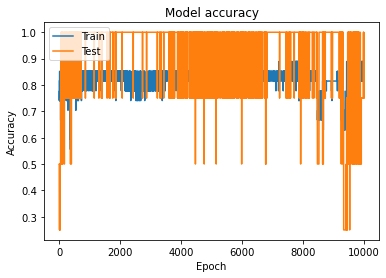

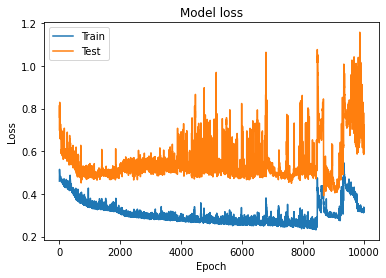

In [55]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## old model for comparison

In [34]:
# Define the Standard model using the top performing parameters from Talos
old_Standard_model = Sequential()
old_Standard_model.add(Dense(8, input_dim=1, activation='relu'))
old_Standard_model.add(Dense(64, activation='relu'))
old_Standard_model.add(Dense(64, activation='relu'))
old_Standard_model.add(Dense(56, activation='relu'))
old_Standard_model.add(Dense(48, activation='relu'))
old_Standard_model.add(Dense(40, activation='relu'))
old_Standard_model.add(Dense(32, activation='relu'))
old_Standard_model.add(Dense(24, activation='relu'))
old_Standard_model.add(Dense(16, activation='relu'))
old_Standard_model.add(Dense(8, activation='relu'))
old_Standard_model.add(Dense(3, activation='linear'))
old_Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = old_Standard_model.fit(train_features_Standard,
                             train_labels_Standard,
                             validation_data=(validation_features_Standard, validation_labels_Standard),
                             batch_size=20,
                             epochs=1000,
                             verbose=0)

poch 801/1000
2/2 - 0s - loss: 0.3900 - accuracy: 0.7778 - val_loss: 0.7312 - val_accuracy: 0.5000
Epoch 802/1000
2/2 - 0s - loss: 0.3866 - accuracy: 0.7778 - val_loss: 0.7590 - val_accuracy: 0.5000
Epoch 803/1000
2/2 - 0s - loss: 0.3884 - accuracy: 0.8148 - val_loss: 0.7803 - val_accuracy: 0.5000
Epoch 804/1000
2/2 - 0s - loss: 0.3847 - accuracy: 0.8148 - val_loss: 0.7724 - val_accuracy: 0.5000
Epoch 805/1000
2/2 - 0s - loss: 0.3828 - accuracy: 0.8148 - val_loss: 0.7761 - val_accuracy: 0.5000
Epoch 806/1000
2/2 - 0s - loss: 0.3872 - accuracy: 0.8148 - val_loss: 0.7991 - val_accuracy: 0.5000
Epoch 807/1000
2/2 - 0s - loss: 0.3775 - accuracy: 0.8519 - val_loss: 0.7988 - val_accuracy: 0.5000
Epoch 808/1000
2/2 - 0s - loss: 0.3841 - accuracy: 0.7778 - val_loss: 0.7983 - val_accuracy: 0.5000
Epoch 809/1000
2/2 - 0s - loss: 0.3855 - accuracy: 0.7778 - val_loss: 0.7953 - val_accuracy: 0.5000
Epoch 810/1000
2/2 - 0s - loss: 0.3836 - accuracy: 0.8519 - val_loss: 0.8070 - val_accuracy: 0.5000
E

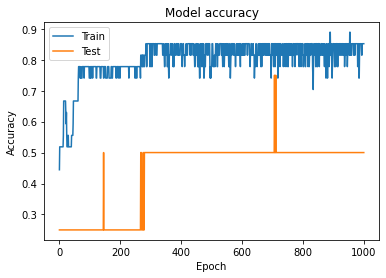

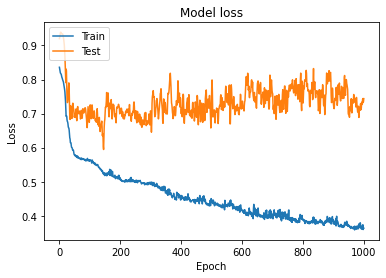

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
# Standard prediction on validation
prediction = old_Standard_model.predict(test_features_Standard)
test_prediction = np.concatenate([prediction, test_features_Standard], axis=1)
test = StandardScaler.inverse_transform(test_prediction)
# compare
print('\nTest input data (desired Ra):\n\n', test[:, 3])
print('\nTrue test output data (RPM, Feed, DOC):\n\n', np_data[27, 0:3])
print('\nPredicted output data (RPM, Feed, DOC):\n\n', test[:, 0:3])


Test input data (desired Ra):

[0.21]

True test output data (RPM, Feed, DOC):

[1100.      0.05    0.4 ]

Predicted output data (RPM, Feed, DOC):

[[974.61913284   0.04622539   0.33140926]]


def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(1, 1)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.mean_absolute_error(train_features_Standard, train_labels_Standard), 
                metrics = ['accuracy'])
  
  return model

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')  

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

print(train_features_Standard.shape)
print(train_labels_Standard.shape)
print(validation_features_Standard.shape)
print(validation_labels_Standard.shape)

tuner.search(train_features_Standard, train_labels_Standard, epochs = 10, validation_data = (validation_features_Standard, validation_labels_Standard), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Define the Standard model using the top performing parameters from Talos
Standard_model = Sequential()
Standard_model.add(Dense(8, input_dim=1, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(56, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(40, activation='relu'))
Standard_model.add(Dense(32, activation='relu'))
Standard_model.add(Dense(24, activation='relu'))
Standard_model.add(Dense(16, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

history = Standard_model.fit(train_features_Standard,
                             train_labels_Standard,
                             validation_data=(validation_features_Standard, validation_labels_Standard),
                             batch_size=20,
                             epochs=1000,)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)
# compare
print('\nValidation input data (desired Ra):\n\n', validation[:, 3])
print('\nTrue validation output data (RPM, Feed, DOC):\n\n', np_data[27, 0:3])
print('\nPredicted output data (RPM, Feed, DOC):\n\n', validation[:, 0:3])

Standard_rpm_error = ((np_data[27, 0:3][0] - validation[0][0])/np_data[27, 0:3][0])*100
Standard_feed_error = ((np_data[27, 0:3][1] - validation[0][1])/np_data[27, 0:3][1])*100
Standard_doc_error = ((np_data[27, 0:3][2] - validation[0][2])/np_data[27, 0:3][2])*100
Standard_average_error = (np.absolute(Standard_rpm_error) + np.absolute(Standard_feed_error) + np.absolute(Standard_doc_error)) / 3

print('\nPercent Errors:\n')
print('RPM : ', np.absolute(Standard_rpm_error))
print('Feed rate : ', np.absolute(Standard_feed_error))
print('Depth of cut : ', np.absolute(Standard_doc_error))
print('Average : ', Standard_average_error)